# Prétaitement des données

In [199]:
# data and plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# pipeline
from sklearn.pipeline import Pipeline

# Machine learning classifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# GridsearchCV
from sklearn import model_selection
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, recall_score, roc_auc_score, f1_score


In [200]:
# Read
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

# TARGET : 0 or 1

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [691]:
app_train_api = pd.read_csv('application_train.csv')
app_train_api = app_train_api.sample(10000, random_state=0)
import joblib
joblib.dump(app_train_api,'app_train_api.joblib')
app_train_api['TARGET'].value_counts()

# Exploratory Data Analysis

In [201]:
# the Distribution of the Target Column can tell us number of customers into each category
app_train['TARGET'].value_counts()

'''Two classes imbalanced'''

'Two classes imbalanced'

<AxesSubplot: xlabel='TARGET', ylabel='Count'>

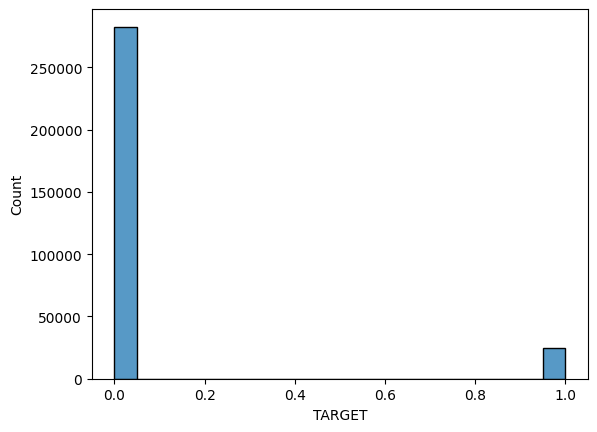

In [202]:
# Histplot of TARGET number
sns.histplot(data=app_train, x="TARGET")

* From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

# Examine Missing Values
##### Next we can look at the number and percentage of missing values in each column.

In [203]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [204]:
# Missing values table
missing_values = missing_values_table(app_train)
missing_values.head(10)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [205]:
app_train['TARGET'].isnull().sum()/len(app_train['TARGET'])
# no missing value in colunm TARGET

0.0

* When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

# Column Types

In [206]:
# Number of each type of column
app_train.dtypes.value_counts()
# We have 16 column which contain categorical features. 

float64    65
int64      41
object     16
dtype: int64

In [207]:
# Number of unique classes excluded NA values in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

* The most of object colomn have a relatively small number of unique types except ORGANIZATION_TYPE and OCCUPATION_TYPE  

# Encoding Categorical Variables


#### We need to encode categorical variables for machine learning classification. There are two main way to encode categorical variables.
#### 1. Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. 
#### 2. One-hot encoding: create a new column for each unique category in a categorical variable.

In [208]:
# Create a label encoder object
le = preprocessing.LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories excluded NA value
        if len(list(app_train[col].dropna().unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])   
                    
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [209]:
app_train.shape
# No new columns are created

(307511, 122)

In [210]:
# One-hot encoding with get_dummies
app_train = pd.get_dummies(app_train)
app_train.shape

(307511, 242)

# Back to Exploratory Data Analysis

In [187]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

* Those ages look reasonable. 

In [15]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

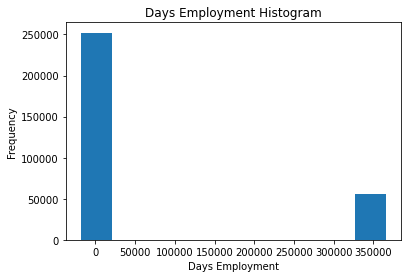

In [15]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [16]:
# let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.
anom = app_train.loc[app_train['DAYS_EMPLOYED'] == 365243,:]
non_anom = app_train.loc[app_train['DAYS_EMPLOYED'] != 365243, :]

In [17]:
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


#### Correlations

##### The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”

In [18]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

/var/folders/xt/m9jq1g_54t7ftbm41cv_xzzr0000gn/T/ipykernel_24564/930648012.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = app_train.corr()['TARGET'].sort_values()


Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
EMERGENCYSTATE_MODE            0.041955
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


* Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

# Imputing missing values and normalization

In [212]:
# Median imputation (sample)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
train = app_train.drop(columns = ['TARGET','SK_ID_CURR'])

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)

# Scale each feature
scaler = StandardScaler()

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)

print('Training data shape: ', train.shape)


Training data shape:  (307511, 240)


# Modelisation with machine learning

In [213]:
# Create a dataframe for dataset selection
train_table = pd.DataFrame(train)
A = app_train.drop(columns = ['TARGET','SK_ID_CURR'])
train_table.columns = A.columns
train_table['TARGET'] = app_train['TARGET'].to_list()


In [216]:
# Selection under sample from dataset in order to reduce the train time
train_sample = train_table.sample(50000, random_state = 0)

In [217]:
# this sample has a small quantitie of client who has a difficulty of payment.
train_sample['TARGET'].value_counts()

0    46060
1     3940
Name: TARGET, dtype: int64

In [218]:
train_sample

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
42962,-0.324395,-0.717914,-1.504820,-0.577538,-0.218443,-0.452190,-0.477250,-0.482865,-0.044979,-1.314626,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,1
227307,-0.324395,-0.717914,0.664531,-0.577538,1.185892,0.102000,0.286544,-0.239153,1.832942,-0.564165,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,1.912181,-0.516781,-0.133215,0
290035,3.082659,1.392925,0.664531,-0.577538,1.185892,0.747780,1.234456,0.979407,-0.739276,-0.469068,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,1.912181,-0.516781,-0.133215,0
239833,-0.324395,1.392925,-1.504820,0.807273,0.806342,1.306800,0.408255,1.588687,-0.161526,0.851973,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,0
76427,-0.324395,1.392925,0.664531,-0.577538,2.134768,0.587229,1.085423,0.370127,-0.011215,1.348767,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,1.935056,-0.133215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54135,-0.324395,-0.717914,-1.504820,-0.577538,0.142129,0.333647,0.825236,0.382313,1.832942,0.233960,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,1.935056,-0.133215,0
58218,3.082659,-0.717914,0.664531,-0.577538,0.616567,-1.096986,-1.327048,-1.031217,-0.149452,-0.593267,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,0
24019,-0.324395,-0.717914,0.664531,-0.577538,-0.237421,-0.929280,-0.979304,-0.848433,-0.044979,0.332493,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,1.912181,-0.516781,-0.133215,0
116685,-0.324395,-0.717914,0.664531,-0.577538,0.331904,0.387995,0.645155,0.370127,-1.141191,-0.713111,...,-0.069989,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,0


In [222]:
# save my sample 
import joblib

joblib.dump(train_sample, 'train_sample.joblib')

['train_sample.joblib']

In [224]:
# training data, testing data
X = train_sample.drop(columns = ['TARGET'])
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = train_sample['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [232]:
# Fonction for hyperparameter search and performance score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def hyperparameter_search(model, param_grid):
    # define search
    grid_pred = model_selection.GridSearchCV(estimator=model,
                                            param_grid=param_grid,
                                            cv=5,
                                            scoring='roc_auc')

    # execute search
    grid_pred.fit(X_train, y_train)

    # predicion with X_test 
    print(grid_pred.best_params_)
    best_grid = grid_pred.best_estimator_
    y_test_pred = best_grid.predict(X_test)

    # Metric score in ordre to evaluate performance
    cm = confusion_matrix(y_test, y_test_pred)

    y_score_test = best_grid.predict_proba(X_test)[:, 1]
    roc_score_model = roc_auc_score(y_test, y_score_test)

    recall_score_model = recall_score(y_test, y_test_pred)

    f1_score_model = f1_score(y_test, y_test_pred)

    print('Confusion matrix ', cm)
    print('     ')
    print('roc_auc_score ', roc_score_model)
    print('     ')
    print('recall_score ',  recall_score_model)
    print('     ')
    print('f1_score ', f1_score_model)
    
    ConfusionMatrixDisplay.from_estimator(best_grid, X_test, y_test)
    plt.show()



#### 1. DummyClassifier (Baseline)

In [227]:
#Dummy classifier (Baseline)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_predict_dummy_clf = dummy_clf.predict(X_test)

In [228]:
#Score in ordre to evaluate performance

cm_dy = confusion_matrix(y_test, y_predict_dummy_clf)

y_score_test_dy = dummy_clf.predict_proba(X_test)[:, 1]
roc_score_dy = roc_auc_score(y_test, y_score_test_dy)

recall_score_dy = recall_score(y_test, y_predict_dummy_clf)

f1_score_dy = f1_score(y_test, y_predict_dummy_clf)

print('Confusion matrix ', cm_dy)
print('     ')
print('roc_auc_score ', roc_score_dy)
print('     ')
print('recall_score ', recall_score_dy)
print('     ')
print('f1_score ', f1_score_dy)

Confusion matrix  [[9213    0]
 [ 787    0]]
     
roc_auc_score  0.5
     
recall_score  0.0
     
f1_score  0.0


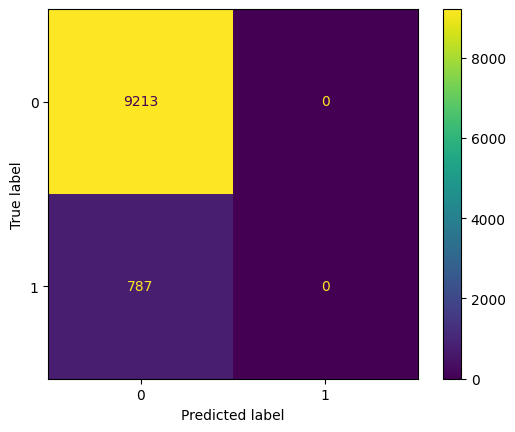

In [229]:
# matrix confusion plot
predictions = dummy_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels= dummy_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=dummy_clf.classes_)
disp.plot()
plt.show()


#### 2. Logistic regression

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

{'C': 0.15848931924611143, 'penalty': 'l1', 'solver': 'saga'}
Confusion matrix  [[9209    4]
 [ 786    1]]
     
roc_auc_score  0.7383473245294099
     
recall_score  0.0012706480304955528
     
f1_score  0.0025252525252525255


The max_iter was reached which means the coef_ did not converge


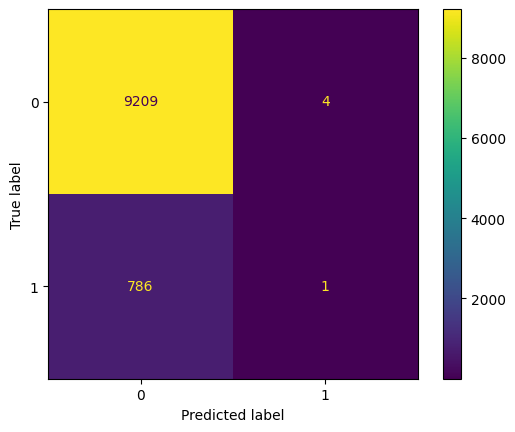

In [233]:
C_range = np.logspace(-4, 4, 6)
param_grid_lr = {'penalty':['l1','l2'],
                 'C': C_range,
                 'solver':['newton-cg','lbfgs', 'saga']
                }

hyperparameter_search(model = LogisticRegression(), param_grid = param_grid_lr)

#### 3. Decision trees

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15}
Confusion matrix  [[9074  139]
 [ 766   21]]
     
roc_auc_score  0.6109788927336116
     
recall_score  0.026683608640406607
     
f1_score  0.04435058078141499


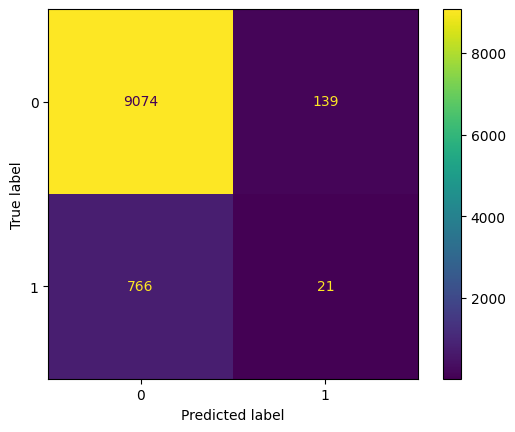

In [234]:
criterion = ['gini', 'entropy']
max_depth_range = [15, 25, 50]
min_samples_split_range = [5, 10, 15]
min_samples_leaf_range = [1,2,5]
max_features_range  = ['sqrt', 'log2']

param_dtc = {'max_features' : max_features_range,
             'max_depth': max_depth_range,
             'min_samples_split': min_samples_split_range,
             'min_samples_leaf': min_samples_leaf_range,
             'criterion' : criterion
             }

hyperparameter_search(model=DecisionTreeClassifier(), param_grid=param_dtc)

#### 4. Random forests

{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 150}
Confusion matrix  [[9213    0]
 [ 787    0]]
     
roc_auc_score  0.7444705157385613
     
recall_score  0.0
     
f1_score  0.0


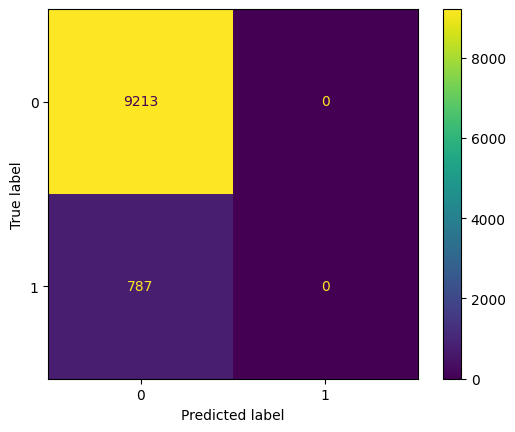

In [235]:
criterion = ['gini','entropy','log_loss']
n_estimators_range = [100, 150]
max_depth_range = [5, 10, 15, 20] 
min_samples_split_range = [2, 3, 4]
min_samples_leaf_range = [5,10]
max_features_range  = ['sqrt','log2']

param_rfc = {'max_features' : max_features_range,
             'max_depth': max_depth_range,
             'min_samples_split': min_samples_split_range,
             'min_samples_leaf': min_samples_leaf_range,
             'n_estimators' : n_estimators_range,
             'criterion' : criterion
             }

hyperparameter_search(model = RandomForestClassifier(), param_grid = param_rfc)

#### 4. Lightgbm

{'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 20, 'reg_alpha': 5.623413251903491, 'reg_lambda': 100.0}
Confusion matrix  [[9212    1]
 [ 785    2]]
     
roc_auc_score  0.7515700357665422
     
recall_score  0.0025412960609911056
     
f1_score  0.005063291139240506


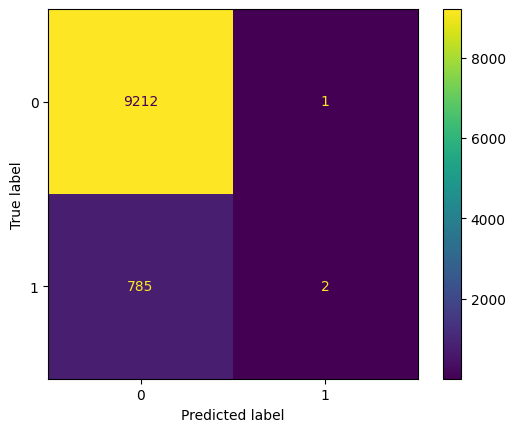

In [236]:
reg_alpha_range = np.logspace(-3, 2, 5)
reg_lambda_range = np.logspace(-3, 2, 5)
max_depth_range = [2, 4, 5]
num_leaves_range = [4,16,20]
learning_rate_range = [1e-3, 1e-2, 1e-1]

param_lgbc = {'reg_alpha': reg_alpha_range,
             'reg_lambda' : reg_lambda_range,
             'max_depth' : max_depth_range,
             'num_leaves' : num_leaves_range,
             'learning_rate' : learning_rate_range
             }

hyperparameter_search(model = lgb.LGBMClassifier(), param_grid = param_lgbc)

#### Table performance before imbalanced datasets treatment

| ----- | Confusion Matrix | Plot| roc_auc_score | recall_score | f1_score |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Dummy Classifier | [9213 0] <br> [ 787 0] | ![sds](cm_baseline.png) | 0.5 | 0.0 | 0.0 |
| Logistic regression | [9209 4] <br> [786 1]| ![sds](cm_lr.png)| 0.738 | 0.001 | 0.002 |
| Decision Trees Classifier | [9074 139] <br> [766 21] | ![sds](cm_dr.png)| 0.610 | 0.027 | 0.044 | 
| Random forest Classifier | [9213 0] <br> [ 787 0] | ![sds](cm_rf.png)| 0.744 | 0.0 | 0.0 |
| Lightgbm Classifier | [9212 1] <br> [785 2] |![sds](cm_lgbm.png) | 0.752 | 0.002 | 0.005 |

###  Classe-weight for regression logistic, decision trees and random forest
#### 1. Logistic regression with parameter class_ weight (balanced)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

{'C': 0.003981071705534973, 'penalty': 'l1', 'solver': 'saga'}
Confusion matrix  [[6396 2817]
 [ 271  516]]
     
roc_auc_score  0.7371097770662994
     
recall_score  0.6556543837357052
     
f1_score  0.25048543689320385


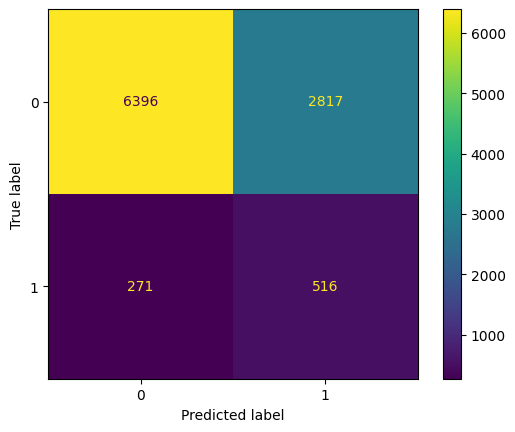

In [237]:
# define parameter 
C_range = np.logspace(-4, 4, 6)
param_grid_lr_cw = {'penalty':['l1','l2'],
                    'C': C_range,
                    'solver':['newton-cg', 'lbfgs', 'saga']
                    }

# execute search
hyperparameter_search(model = LogisticRegression(class_weight='balanced'), param_grid = param_grid_lr_cw)


#### 2. Desicion trees classifier with parameter class-weight(balanced)

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Confusion matrix  [[5653 3560]
 [ 350  437]]
     
roc_auc_score  0.598277377513764
     
recall_score  0.5552731893265566
     
f1_score  0.1826923076923077


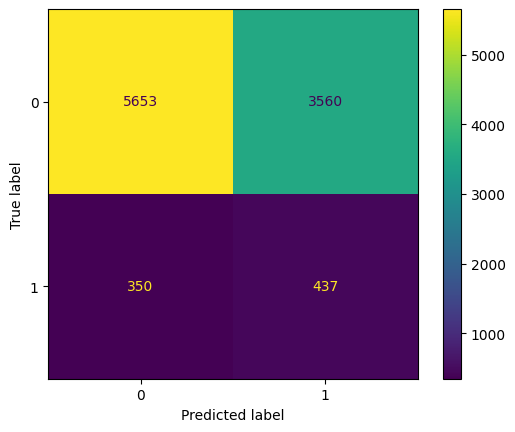

In [238]:
criterion = ['gini', 'entropy']
max_depth_range = [15, 25, 50]
min_samples_split_range = [5, 10, 15]
min_samples_leaf_range = [1,2,5]
max_features_range  = ['sqrt', 'log2']

param_dtc_cw = {'max_features' : max_features_range,
             'max_depth': max_depth_range,
             'min_samples_split': min_samples_split_range,
             'min_samples_leaf': min_samples_leaf_range,
             'criterion' : criterion
             }

hyperparameter_search(model=DecisionTreeClassifier(class_weight='balanced'), param_grid=param_dtc_cw)

#### 3. Random forest classifier with parameter class-weight(balanced)

{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 4, 'n_estimators': 200}
Confusion matrix  [[8395  818]
 [ 523  264]]
     
roc_auc_score  0.737757031077709
     
recall_score  0.3354510800508259
     
f1_score  0.2825040128410915


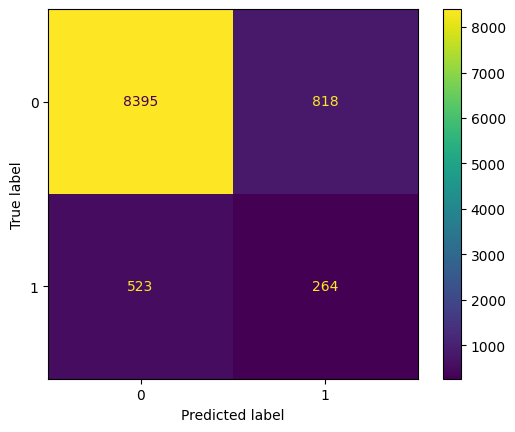

In [239]:
criterion = ['gini','entropy']
n_estimators_range = [150, 200]
max_depth_range = [20, 25, 30] 
min_samples_split_range = [3, 4, 5]
min_samples_leaf_range = [10, 15, 20]
max_features_range  = ['sqrt']

param_rfc_cw = {'max_features' : max_features_range,
                'max_depth': max_depth_range,
                'min_samples_split': min_samples_split_range,
                'min_samples_leaf': min_samples_leaf_range,
                'n_estimators' : n_estimators_range,
                'criterion' : criterion
                }

hyperparameter_search(model = RandomForestClassifier(class_weight='balanced'), param_grid = param_rfc_cw)

####  Lightgbm

{'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 16, 'reg_alpha': 100.0, 'reg_lambda': 0.31622776601683794}
Confusion matrix  [[6496 2717]
 [ 269  518]]
     
roc_auc_score  0.7494670463853421
     
recall_score  0.6581956797966964
     
f1_score  0.2575832918945798


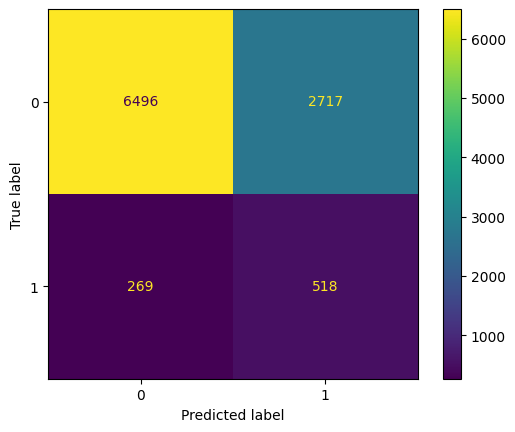

In [240]:
reg_alpha_range = np.logspace(-3, 2, 5)
reg_lambda_range = np.logspace(-3, 2, 5)
max_depth_range = [2, 4, 5]
num_leaves_range = [4,16,20]
learning_rate_range = [1e-3, 1e-2, 1e-1]

param_lgbc_cw = {'reg_alpha': reg_alpha_range,
             'reg_lambda' : reg_lambda_range,
             'max_depth' : max_depth_range,
             'num_leaves' : num_leaves_range,
             'learning_rate' : learning_rate_range
             }

hyperparameter_search(model = lgb.LGBMClassifier(class_weight = 'balanced'), param_grid = param_lgbc_cw)

#### After

| ----- | Confusion Matrix | Plot | roc_auc_score | recall_score | f1_score |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Logistic regression | [6396 2817]<br> [271  516] | ![sds](cm_lr_cw2.png)| 0.737 | 0.656 | 0.250 |
| Decision Trees Classifier | [5653 3560] <br> [350  437] | ![sds](cm_dr_cw2.png)| 0.598 | 0.555 | 0.183 | 
| Random forest Classifier | [8395  818] <br> [523  264] |![sds](cm_fr_cw2.png) | 0.738 | 0.335 | 0.283 |
| Lightgbm Classifier | [6496 2717] <br> [269  518] | ![sds](cm_lgbm_cw2.png)| 0.749 | 0.658 | 0.258 |

## ML Modele choice

### Random forest classifier and Lightgbm classifier because of the high ROC AUC score and a reasonable f1-score 

# Features engineering

### The most important features that I created, in descending order of importance were the following:

* 1. annuity_ratio_income_ratio : AMT_ANNUITY / AMT_INCOME_TOTAL

* 2. credit_annuity_ratio: AMT_CREDIT / AMT_ANNUITY

* 3. credit_goods_price_ratio: AMT_CREDIT / AMT_GOODS_PRICE

* 4. credit_downpayment: AMT_GOODS_PRICE - AMT_CREDIT

In [243]:
# add a colonm 'annuity_ratio_income_ratio' for the complet dataset
train_table['annuity_ratio_income_ratio'] = train_table['AMT_ANNUITY'] / train_table['AMT_INCOME_TOTAL']

In [244]:
# add a colonm 'credit_annuity_ratio' for the complet dataset
train_table['credit_annuity_ratio'] = train_table['AMT_CREDIT'] / train_table['AMT_ANNUITY']

In [245]:
# add a colonm 'credit_goods_price_ratio' for the complet dataset
train_table['credit_goods_price_ratio'] = train_table['AMT_CREDIT'] / train_table['AMT_GOODS_PRICE']

In [246]:
# add a colonm 'credit_downpayment' for the complet dataset
train_table['credit_downpayment'] = train_table['AMT_GOODS_PRICE'] - train_table['AMT_CREDIT']

In [339]:
train_table = train_table.drop(columns = ['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE'])

In [344]:
train_table.shape

(307511, 241)

### Feature engineering for a sample of my data

In [249]:
train_sample['annuity_ratio_income_ratio'] = train_sample['AMT_ANNUITY'] / train_sample['AMT_INCOME_TOTAL']
train_sample['credit_annuity_ratio'] = train_sample['AMT_CREDIT'] / train_sample['AMT_ANNUITY']
train_sample['credit_goods_price_ratio'] = train_sample['AMT_CREDIT'] / train_sample['AMT_GOODS_PRICE']
train_sample['credit_downpayment'] = train_sample['AMT_GOODS_PRICE'] - train_sample['AMT_CREDIT']

In [316]:
train_sample = train_sample.drop(columns = ['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE'])

### Feature importance and feature selection using permutation importance

In [318]:
X = train_sample.drop(columns = ['TARGET'])
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = train_sample.loc[:, 'TARGET']

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20 )

### Feature importance and feature selection for Lightgbm classifier

In [320]:
# Feature importance and feature selection for my best model Lightgbm classifier
from sklearn.inspection import permutation_importance

lgbc = lgb.LGBMClassifier(class_weight = 'balanced',
                         learning_rate = 0.1, 
                         max_depth = 4, 
                         num_leaves = 16, 
                         reg_alpha =  100.0, 
                         reg_lambda = 0.31622776601683794)
lgbc.fit(X_train, y_train)
perm_importance  = permutation_importance(lgbc, X_train, y_train)

In [321]:
# Feature importance in ascending order
feature_names = X.columns
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
features_importances = pd.DataFrame(perm_importance.importances_mean[sorted_idx], features[sorted_idx])
features_importances_lgbm_sorted = features_importances.sort_values(by=[0])
features_importances_lgbm_sorted.head(10)

,0
EXT_SOURCE_1,-0.001950
NAME_EDUCATION_TYPE_Highereducation,-0.001200
FLAG_WORK_PHONE,-0.000835
FLAG_DOCUMENT_3,-0.000825
EMERGENCYSTATE_MODE,-0.000795
NAME_EDUCATION_TYPE_Secondarysecondaryspecial,-0.000735
OBS_60_CNT_SOCIAL_CIRCLE,-0.000550
REGION_RATING_CLIENT_W_CITY,-0.000510
REGION_RATING_CLIENT,-0.000465
AMT_REQ_CREDIT_BUREAU_YEAR,-0.000455


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


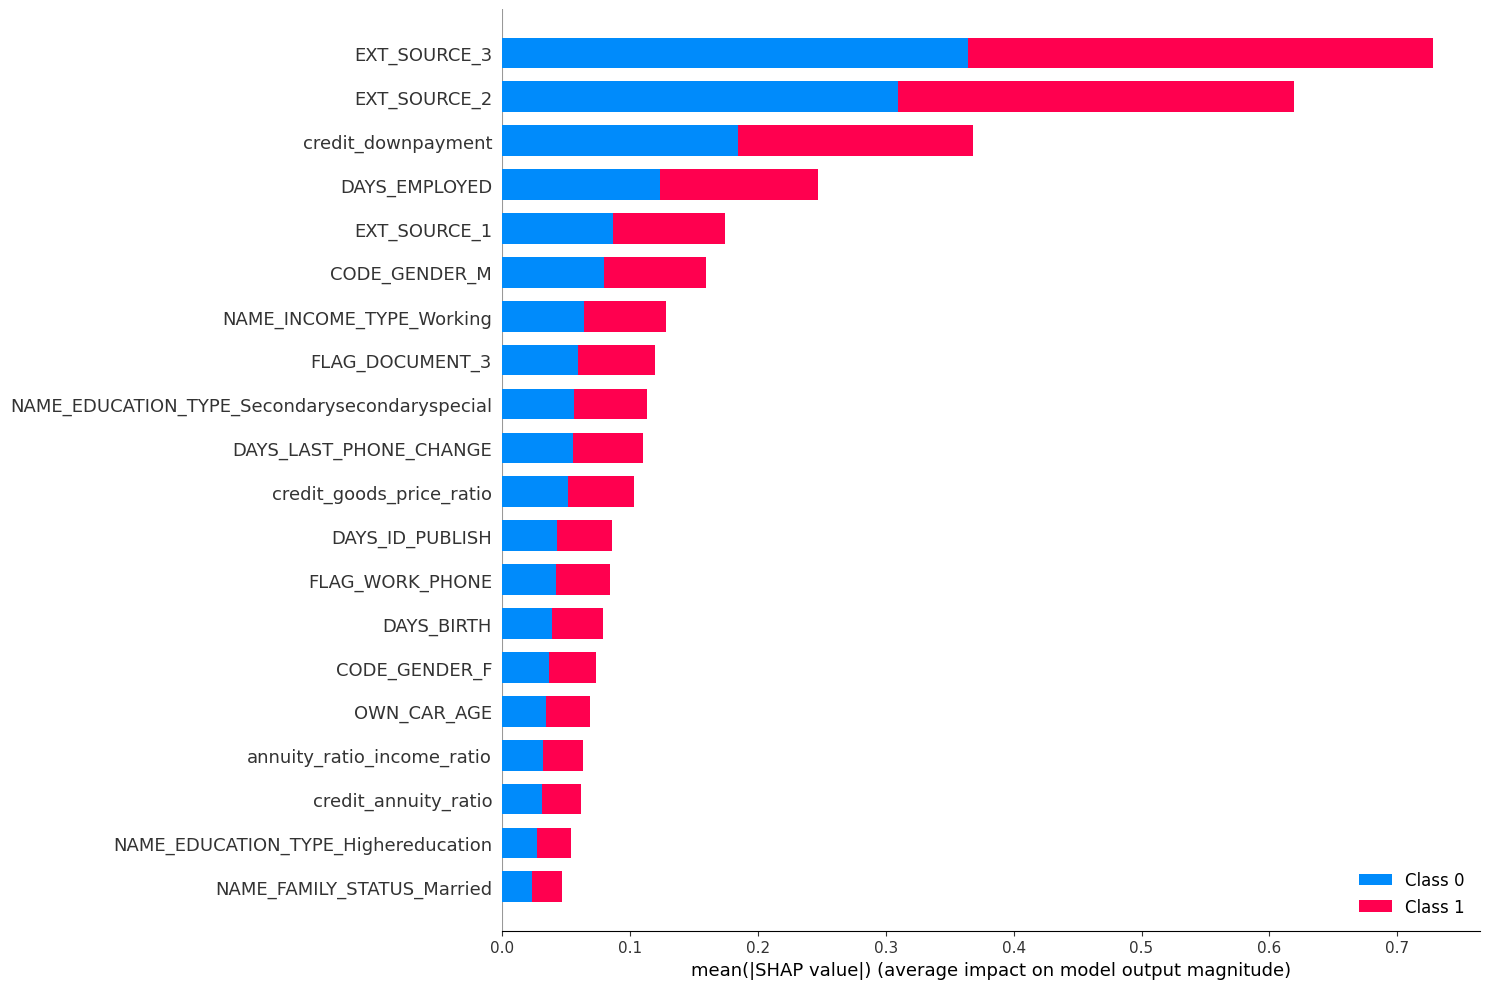

In [322]:
import shap
shap_values = shap.TreeExplainer(lgbc).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (15,10))

In [323]:
# some features important for lightgbm
features_importances_lgbm_sorted.tail(10)

,0
NAME_INCOME_TYPE_Working,0.000450
credit_annuity_ratio,0.000730
FLAG_OWN_CAR,0.000820
OWN_CAR_AGE,0.001205
NAME_FAMILY_STATUS_Married,0.001270
DAYS_EMPLOYED,0.002280
CODE_GENDER_M,0.002885
DAYS_BIRTH,0.003665
EXT_SOURCE_2,0.005055
EXT_SOURCE_3,0.009885


In [325]:
# feature delete for lightgbm

sample_lgbmc_fe = train_sample.drop(columns = ['NAME_EDUCATION_TYPE_Higher education', 
                                                'EMERGENCYSTATE_MODE', 
                                                'NAME_EDUCATION_TYPE_Secondary / secondary special',
                                                'OBS_60_CNT_SOCIAL_CIRCLE',
                                                'REGION_RATING_CLIENT_W_CITY',
                                                'REGION_RATING_CLIENT'])

In [336]:
sample_lgbmc_fe

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET,annuity_ratio_income_ratio,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment
42962,-0.324395,-0.717914,-1.504820,-0.577538,-0.044979,-1.314626,-0.466748,0.106481,-1.098943,-0.146313,...,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,1,2.184774,0.947492,0.936474,-0.030675
227307,-0.324395,-0.717914,0.664531,-0.577538,1.832942,-0.564165,-0.466252,0.549017,0.640103,-0.146313,...,-0.076281,-0.072886,1.912181,-0.516781,-0.133215,0,0.241628,0.355966,-0.426506,-0.341153
290035,3.082659,1.392925,0.664531,-0.577538,-0.739276,-0.469068,-0.481145,-1.004541,0.913051,-0.849033,...,-0.076281,-0.072886,1.912181,-0.516781,-0.133215,0,1.040951,0.605757,0.763502,0.231627
239833,-0.324395,1.392925,-1.504820,0.807273,-0.161526,0.851973,-0.469629,-2.077243,-0.808771,-0.567945,...,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,0,0.506304,3.200943,0.822566,0.281887
76427,-0.324395,1.392925,0.664531,-0.577538,-0.011215,1.348767,-0.469515,0.623672,0.106133,-0.567945,...,-0.076281,-0.072886,-0.522963,1.935056,-0.133215,0,0.508450,0.541014,1.586560,-0.217102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54135,-0.324395,-0.717914,-1.504820,-0.577538,1.832942,0.233960,-0.455522,1.153352,1.516583,-0.146313,...,-0.076281,-0.072886,-0.522963,1.935056,-0.133215,0,5.806239,0.404304,0.872706,0.048666
58218,3.082659,-0.717914,0.664531,-0.577538,-0.149452,-0.593267,-0.489498,0.598976,0.911726,-0.146313,...,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,0,-2.152317,0.826636,1.063778,0.065769
24019,-0.324395,-0.717914,0.664531,-0.577538,-0.044979,0.332493,2.133617,0.019904,-1.273179,-0.146313,...,-0.076281,-0.072886,1.912181,-0.516781,-0.133215,0,4.124759,0.948918,1.095290,0.080847
116685,-0.324395,-0.717914,0.664531,-0.577538,-1.141191,-0.713111,-0.492081,1.168112,0.311506,-0.146313,...,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,0,1.943798,0.601398,1.048273,-0.017867


In [326]:
joblib.dump(sample_lgbmc_fe, 'sample_lgbmc_fe.joblib')

['sample_lgbmc_fe.joblib']

### Feature importance and feature selection for randomforestclassifier

In [435]:
X = train_sample.drop(columns = ['TARGET'])
y = train_sample.loc[:, 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [436]:
# Feature importance and feature selection for randomforestclassifier
rfc = RandomForestClassifier(class_weight = 'balanced',
                            criterion = 'entropy', 
                            max_depth = 30, 
                            max_features = 'sqrt', 
                            min_samples_leaf = 20, 
                            min_samples_split = 4,
                            n_estimators = 200
                            )
rfc.fit(X_train, y_train)
perm_importance_rfc  = permutation_importance(rfc, X_train, y_train)

# feature importance in ascending order
feature_names_rfc = X.columns
features_rfc = np.array(feature_names_rfc)
sorted_idx_rfc = perm_importance_rfc.importances_mean.argsort()
features_importances_rfc = pd.DataFrame(perm_importance_rfc.importances_mean[sorted_idx], features_rfc[sorted_idx])
features_importances_rfc_sorted = features_importances_rfc.sort_values(by=[0])
features_importances_rfc_sorted.head(10)

,0
ELEVATORS_AVG,-0.000450
COMMONAREA_MODE,-0.000425
COMMONAREA_AVG,-0.000300
LIVINGAREA_AVG,-0.000155
LIVINGAPARTMENTS_AVG,-0.000140
FLOORSMIN_MODE,-0.000135
FLOORSMIN_MEDI,-0.000135
ELEVATORS_MEDI,-0.000125
WALLSMATERIAL_MODE_Block,-0.000080
TOTALAREA_MODE,-0.000045


In [444]:
# Features delete
sample_rfc_fe = train_sample.drop(columns = ['ELEVATORS_AVG',
                                                'COMMONAREA_MODE', 
                                                'TOTALAREA_MODE', 
                                                'LIVINGAREA_AVG',
                                                'ELEVATORS_MODE',
                                                'LIVINGAPARTMENTS_AVG',
                                                'FLOORSMIN_MODE',
                                                'COMMONAREA_AVG',
                                                'FLOORSMIN_MEDI',
                                                'ELEVATORS_MEDI'])

In [445]:
sample_rfc_fe.shape

(50000, 231)

In [446]:
joblib.dump(sample_rfc_fe, 'sample_rfc_fe.joblib')

['sample_rfc_fe.joblib']

# Lightgbm classification after feature engineering

In [329]:
# split training set and testing set
X_lgbm_fe = sample_lgbmc_fe.drop(columns = ['TARGET'])
X_lgbm_fe = X_lgbm_fe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_lgbm_fe = sample_lgbmc_fe.loc[:, 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_lgbm_fe , y_lgbm_fe , test_size=0.20)

{'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 8, 'reg_alpha': 0.31622776601683794, 'reg_lambda': 100.0}
Confusion matrix  [[6518 2740]
 [ 242  500]]
     
roc_auc_score  0.7570369678092932
     
recall_score  0.6738544474393531
     
f1_score  0.251130085384229


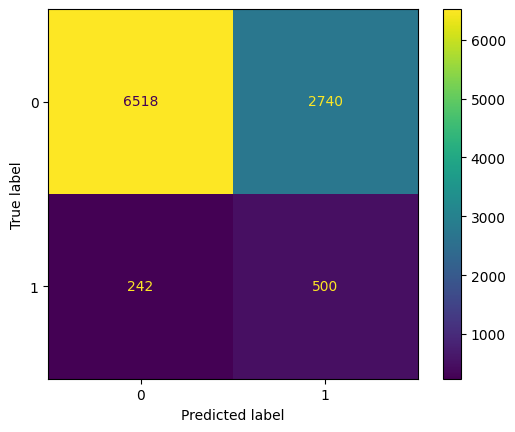

In [332]:
reg_alpha_range = np.logspace(-3, 2, 5)
reg_lambda_range = np.logspace(-3, 2, 5)
max_depth_range = [2, 3, 4, 5]
num_leaves_range = [4, 8, 16, 20]
learning_rate_range = [1e-3, 1e-2, 1e-1]

param_lgbc_fe = {'reg_alpha': reg_alpha_range,
             'reg_lambda' : reg_lambda_range,
             'max_depth' : max_depth_range,
             'num_leaves' : num_leaves_range,
             'learning_rate' : learning_rate_range
             }

hyperparameter_search(model = lgb.LGBMClassifier(class_weight = 'balanced'), param_grid = param_lgbc_fe)

# Random forest classification after feature engineering

In [447]:
X_rfc_fe = sample_rfc_fe.drop(columns = ['TARGET'])
y_rfc_fe = sample_rfc_fe.loc[:, 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_rfc_fe , y_rfc_fe , test_size=0.20)

{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 3, 'n_estimators': 200}
Confusion matrix  [[8320  885]
 [ 512  283]]
     
roc_auc_score  0.7423699862325301
     
recall_score  0.3559748427672956
     
f1_score  0.2883341823739175


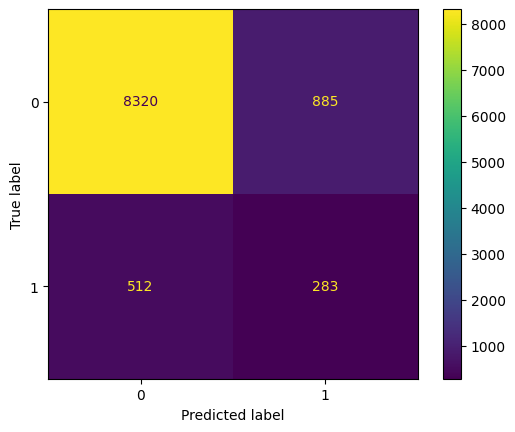

In [448]:
criterion = ['gini','entropy']
n_estimators_range = [150, 200]
max_depth_range = [10, 15, 20] 
min_samples_split_range = [3, 4,5]
min_samples_leaf_range = [15, 20]
max_features_range  = ['sqrt']

param_rfc_fe = {'max_features' : max_features_range,
                'max_depth': max_depth_range,
                'min_samples_split': min_samples_split_range,
                'min_samples_leaf': min_samples_leaf_range,
                'n_estimators' : n_estimators_range,
                'criterion' : criterion
                }

hyperparameter_search(model = RandomForestClassifier(class_weight='balanced'), param_grid = param_rfc_fe)

# Table after feature engineering

* Récapitulatif des améliorations, Cette étape est validée si ROC AUC augmente même légèrement et pas de diminution sur les autres métriques.

## version 2

| ----- | Confusion Matrix | Plot | roc_auc_score | recall_score | f1_score |
| :-: | :-: | :-: | :-: | :-: | :-: |
|Random forest Classifier | [8395  818] <br> [523  264] |![sds](cm_fr_cw2.png) | 0.738 | 0.335 | 0.283 |
| Random forest Classifier (after FE)| [8320  885] <br> [512  283] |![sds](cm_rf_fe2.png) | 0.742 | 0.356 | 0.288 |
| Lightgbm Classifier (before FE) | [6496 2717] <br> [269  518] | ![sds](cm_lgbm_cw2.png))| 0.749 | 0.658 | 0.258 |
| Lightgbm Classifier (after FE) | [6518 2740] <br> [242  500] |![sds](cm_lgbm_fe.png)| 0.757 | 0.674 | 0.251 |

# Fbeta_score (a new metric)


In [392]:
from sklearn.metrics import fbeta_score, make_scorer

def hyperparameter_search_fbeta_score(model, param_grid):
    # define search
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    grid_pred = model_selection.GridSearchCV(estimator=model,
                                            param_grid=param_grid,
                                            cv=5,
                                            scoring=ftwo_scorer)

    # execute search
    grid_pred.fit(X_train, y_train)

    # predicion with X_test 
    print(grid_pred.best_params_)
    best_grid = grid_pred.best_estimator_
    y_test_pred = best_grid.predict(X_test)

    # Metric score in ordre to evaluate performance
    cm = confusion_matrix(y_test, y_test_pred)

    y_score_test = best_grid.predict_proba(X_test)[:, 1]
    roc_score_model = roc_auc_score(y_test, y_score_test)

    recall_score_model = recall_score(y_test, y_test_pred)

    f1_score_model = f1_score(y_test, y_test_pred)

    fbeta_score_model = fbeta_score(y_test, y_test_pred, beta=2)

    print('Confusion matrix ', cm)
    print('     ')
    print('roc_auc_score ', roc_score_model)
    print('     ')
    print('recall_score ',  recall_score_model)
    print('     ')
    print('f1_score ', f1_score_model)
    print('     ')
    print('fbeta_score ', fbeta_score_model)

    ConfusionMatrixDisplay.from_estimator(best_grid, X_test, y_test)
    plt.show()

In [552]:
X_rfc_fe = sample_rfc_fe.drop(columns = ['TARGET'])
y_rfc_fe = sample_rfc_fe.loc[:, 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_rfc_fe , y_rfc_fe , test_size=0.20)

{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 200}
Confusion matrix  [[7948 1280]
 [ 463  309]]
     
roc_auc_score  0.7238015748420553
     
recall_score  0.40025906735751293
     
f1_score  0.26175349428208383
     
fbeta_score  0.3303399615137909


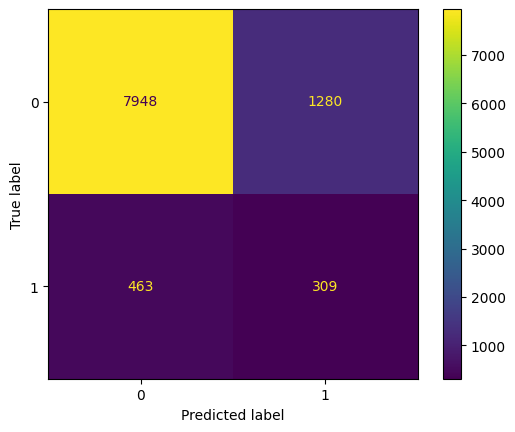

In [554]:
# Random forest 
criterion = ['gini', 'entropy', 'log_loss']
n_estimators_range = [150, 200]
max_depth_range = [15, 20, 25, 30] 
min_samples_split_range = [3, 4, 5]
min_samples_leaf_range = [10, 15, 20]
max_features_range  = ['sqrt']

param_rfc_fbeta = {'max_features' : max_features_range,
                'max_depth': max_depth_range,
                'min_samples_split': min_samples_split_range,
                'min_samples_leaf': min_samples_leaf_range,
                'n_estimators' : n_estimators_range,
                'criterion' : criterion
                }

hyperparameter_search_fbeta_score(model = RandomForestClassifier(class_weight='balanced'), param_grid = param_rfc_fbeta)

In [166]:
# Lightgbm classifier
X_lgbm_fe = sample_lgbmc_fe.drop(columns = ['TARGET'])
X_lgbm_fe = X_lgbm_fe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_lgbm_fe = sample_lgbmc_fe.loc[:, 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_lgbm_fe , y_lgbm_fe , test_size=0.20)

{'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 8, 'reg_alpha': 0.31622776601683794, 'reg_lambda': 100.0}
Confusion matrix  [[6518 2740]
 [ 242  500]]
     
roc_auc_score  0.7570369678092932
     
recall_score  0.6738544474393531
     
f1_score  0.251130085384229
     
fbeta_score  0.40270618556701027


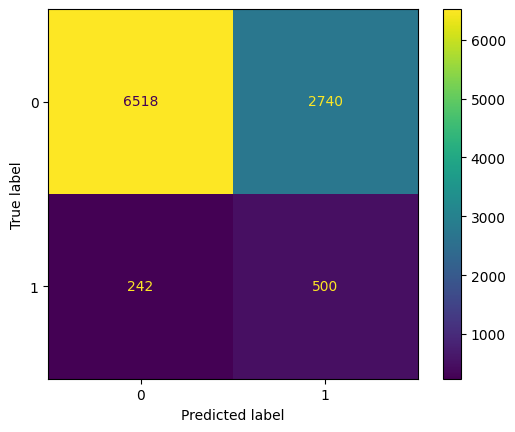

In [335]:
# Lightgbm
reg_alpha_range = np.logspace(-3, 2, 5)
reg_lambda_range = np.logspace(-3, 2, 5)
max_depth_range = [3, 4, 5, 6]
num_leaves_range = [4, 8, 16,20]
learning_rate_range = [1e-3, 1e-2, 1e-1]

param_lgbc_fbeta = {'reg_alpha': reg_alpha_range,
             'reg_lambda' : reg_lambda_range,
             'max_depth' : max_depth_range,
             'num_leaves' : num_leaves_range,
             'learning_rate' : learning_rate_range
             }

hyperparameter_search_fbeta_score(model = lgb.LGBMClassifier(class_weight = 'balanced'), param_grid = param_lgbc_fbeta)

### Table after considering fbeta_socre as scoring


| ----- | Confusion Matrix | Plot | roc_auc_score | recall_score | f1_score | fbeta_score|
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|Random forest Classifier (before FE)| [8395  818] <br> [523  264] |![sds](cm_fr_cw2.png) | 0.738 | 0.335 | 0.283 | | |
| Random forest Classifier (after FE)| [8320  885] <br> [512  283] |![sds](cm_rf_fe2.png) | 0.742 | 0.356 | 0.288 |
| Random forest Classifier (with fbeta)| [7948 1280] <br> [463  309] | ![sds](cm_rf_fb2.png) | 0.724| 0.400 | 0.262 | 0.330 |
| Lightgbm Classifier (before FE) | [6496 2717] <br> [269  518] | ![sds](cm_lgbm_cw2.png))| 0.749 | 0.658 | 0.258 | |
| Lightgbm Classifier (after FE) | [6518 2740] <br> [242  500] |![sds](cm_lgbm_fe.png)| 0.757 | 0.674 | 0.251 ||
| Lightgbm Classifier (with fbeta) | [6518 2740] <br> [242  500] | ![sds](cm_lgbm_fb.png)| 0.757| 0.674 | 0.251 | 0.407 |

### Since my best model has been choiced, now I'm going to realize the machine learning classification using complet datas with model lightgbm

In [491]:
# creat complet_data_lgbm 

complet_data_lgbm = train_table.drop(columns = ['EMERGENCYSTATE_MODE',
                                                'NAME_EDUCATION_TYPE_Higher education', 
                                                'OBS_60_CNT_SOCIAL_CIRCLE', 
                                                'REGION_RATING_CLIENT_W_CITY',
                                                'REGION_RATING_CLIENT',
                                                'NAME_EDUCATION_TYPE_Secondary / secondary special'])

X_lgbm_fe = complet_data_lgbm.drop(columns = ['TARGET'])
X_lgbm_fe = X_lgbm_fe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_lgbm_fe = complet_data_lgbm.loc[:, 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_lgbm_fe , y_lgbm_fe , test_size=0.20)

{'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 16, 'reg_alpha': 0.01778279410038923, 'reg_lambda': 5.623413251903491}
Confusion matrix  [[39323 17280]
 [ 1560  3340]]
     
roc_auc_score  0.7556351343604417
     
recall_score  0.6816326530612244
     
f1_score  0.2617554858934169
     
fbeta_score  0.41521631029338635


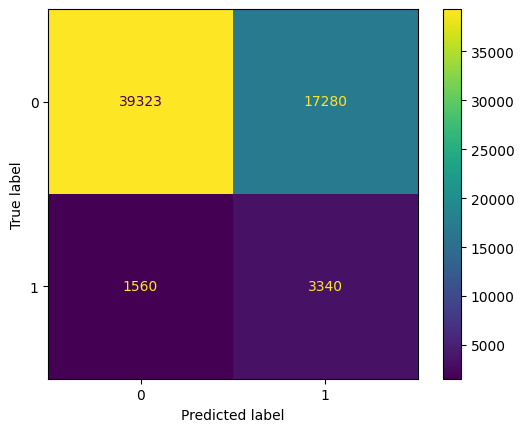

In [496]:
# Lightgbm classification
reg_alpha_range = np.logspace(-3, 2, 5)
reg_lambda_range = np.logspace(-3, 2, 5)
max_depth_range = [3, 4, 5, 6]
num_leaves_range = [4, 8, 16,20]
learning_rate_range = [1e-3, 1e-2, 1e-1]

param_lgbc_fbeta = {'reg_alpha': reg_alpha_range,
             'reg_lambda' : reg_lambda_range,
             'max_depth' : max_depth_range,
             'num_leaves' : num_leaves_range,
             'learning_rate' : learning_rate_range
             }

hyperparameter_search_fbeta_score(model = lgb.LGBMClassifier(class_weight = 'balanced'), param_grid = param_lgbc_fbeta)

# Classification threshold for LGBMClassifier
* Lightgbm is the best model for my projet, so in the next step, I'm going to look for a probabity threshold in order to obtain the higest fbeta-score

In [499]:
# Model Lightgbm with complet dataset using hyperparameter found in the last step

lgbm_thre = lgb.LGBMClassifier(class_weight = 'balanced',
                              learning_rate = 0.1, 
                              max_depth = 6, 
                              num_leaves = 16, 
                              reg_alpha = 0.01778279410038923, 
                              reg_lambda = 5.623413251903491)
lgbm_thre.fit(X_train, y_train)


LGBMClassifier(class_weight='balanced', max_depth=6, num_leaves=16,
               reg_alpha=0.01778279410038923, reg_lambda=5.623413251903491)

In [502]:
# F-beta score in funtion of threshold

threshold = np.arange(0, 1.0, 0.001)
fbeta_list= []
thre_list= []
for i in threshold:
    thre_list.append(i)
    predicted_proba = lgbm_thre.predict_proba(X_test)
    predicted = (predicted_proba[:,1] >= i).astype('int')
    f_beta = fbeta_score(y_test, predicted, beta = 2)
    fbeta_list.append(f_beta)
    fbeta_thre_table = pd.DataFrame(list(zip(thre_list, fbeta_list)),
                                            columns =['threshold', 'fbeta_score'])
                                            
print(fbeta_thre_table)

     threshold  fbeta_score
0        0.000     0.302085
1        0.001     0.302085
2        0.002     0.302085
3        0.003     0.302085
4        0.004     0.302085
..         ...          ...
995      0.995     0.000000
996      0.996     0.000000
997      0.997     0.000000
998      0.998     0.000000
999      0.999     0.000000

[1000 rows x 2 columns]


     threshold  fbeta_score
522      0.522     0.417361


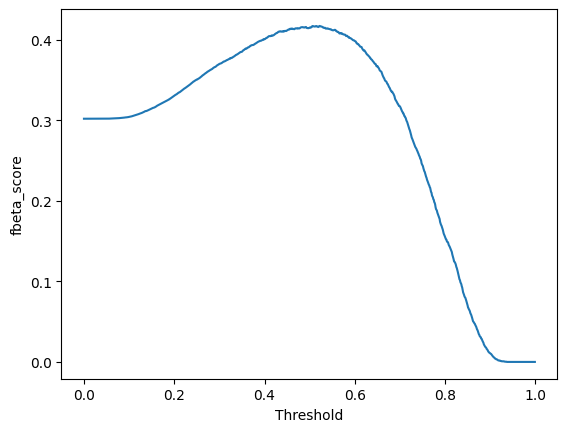

In [503]:
# The threshold maxmal and fbeta_score corresponding
print(fbeta_thre_table[fbeta_thre_table.fbeta_score == fbeta_thre_table.fbeta_score.values.max()])

# Plot fbeta in function of threshold
fig_fbeta_thre = plt.figure()
ax_fbeta_thre = plt.axes()
plt.xlabel('Threshold')
plt.ylabel('fbeta_score')
ax_fbeta_thre.plot(thre_list, fbeta_list)

In [529]:
threshold_proba = fbeta_thre_table.loc[fbeta_thre_table.fbeta_score == fbeta_thre_table.fbeta_score.values.max(), 'threshold']

In [530]:
threshold_proba = threshold_proba.values[0]

# Model analyse (feature importance) for my best model

## Feature importance for LightGBM (shap)

In [556]:
X_lgbm_fe = complet_data_lgbm.drop(columns = ['TARGET','SK_ID_CURR'])
X_lgbm_fe = X_lgbm_fe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_lgbm_fe = complet_data_lgbm.loc[:, 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_lgbm_fe , y_lgbm_fe , test_size=0.20)

lgbm_thre = lgb.LGBMClassifier(class_weight = 'balanced',
                              learning_rate = 0.1, 
                              max_depth = 6, 
                              num_leaves = 16, 
                              reg_alpha = 0.01778279410038923, 
                              reg_lambda = 5.623413251903491)
lgbm_thre.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', max_depth=6, num_leaves=16,
               reg_alpha=0.01778279410038923, reg_lambda=5.623413251903491)

## Variable Importance Plot — Global Interpretability (summary_plot lightgbm)

In [571]:
import shap
explainer = shap.TreeExplainer(lgbm_thre)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


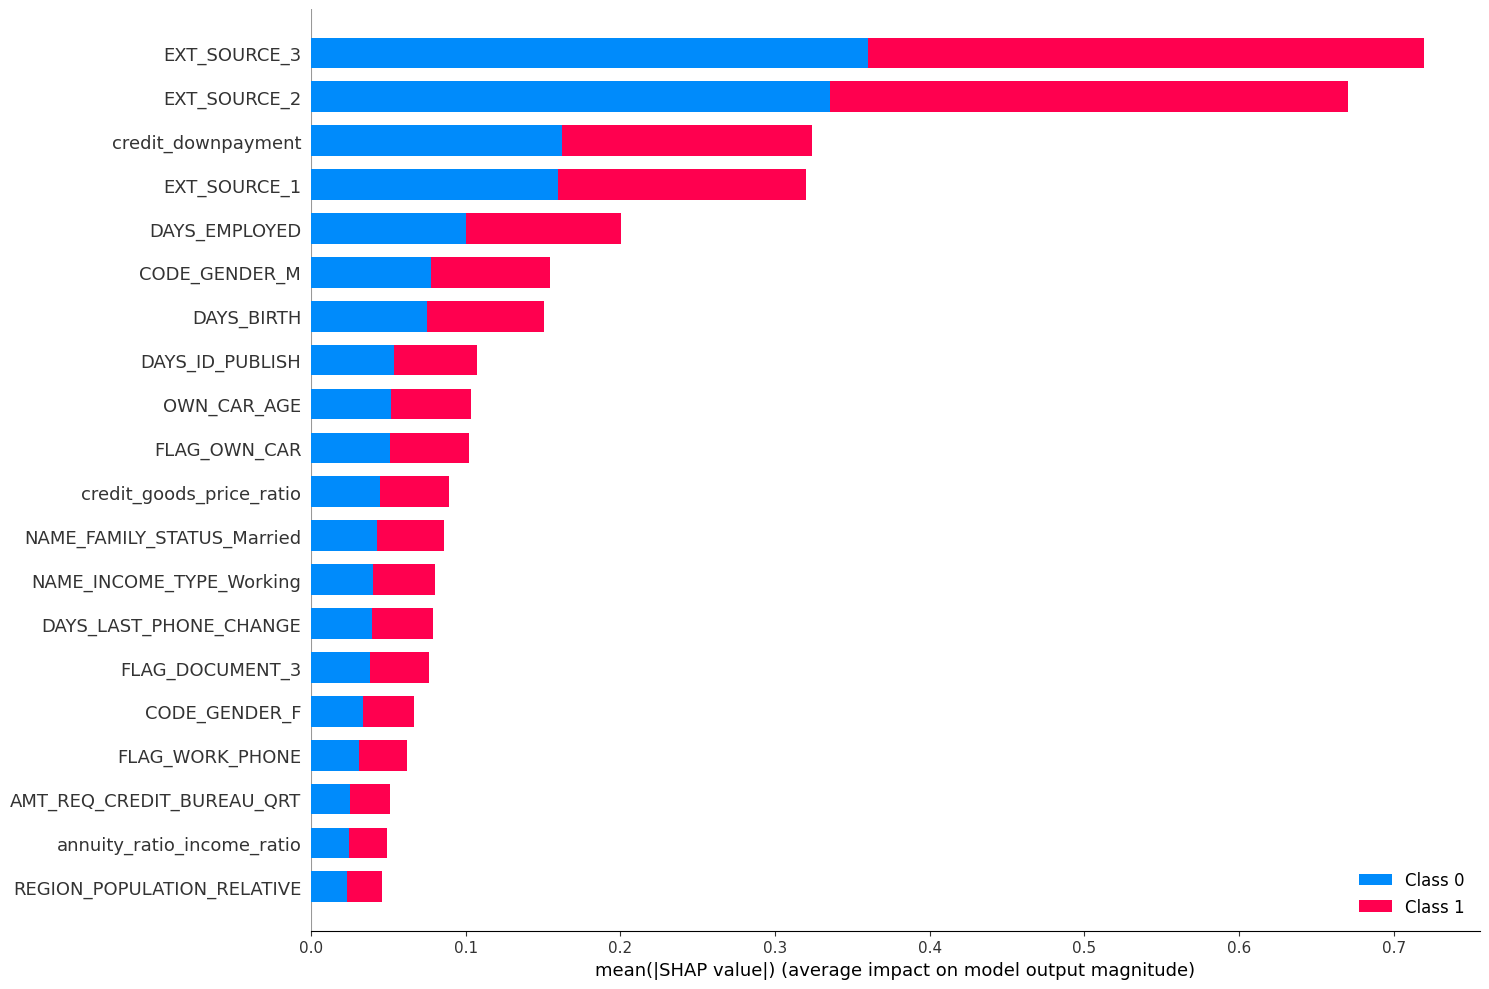

In [543]:
# Summary_plot LightGBM
shap.summary_plot(shap_values, X_train, plot_size = (15,10))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


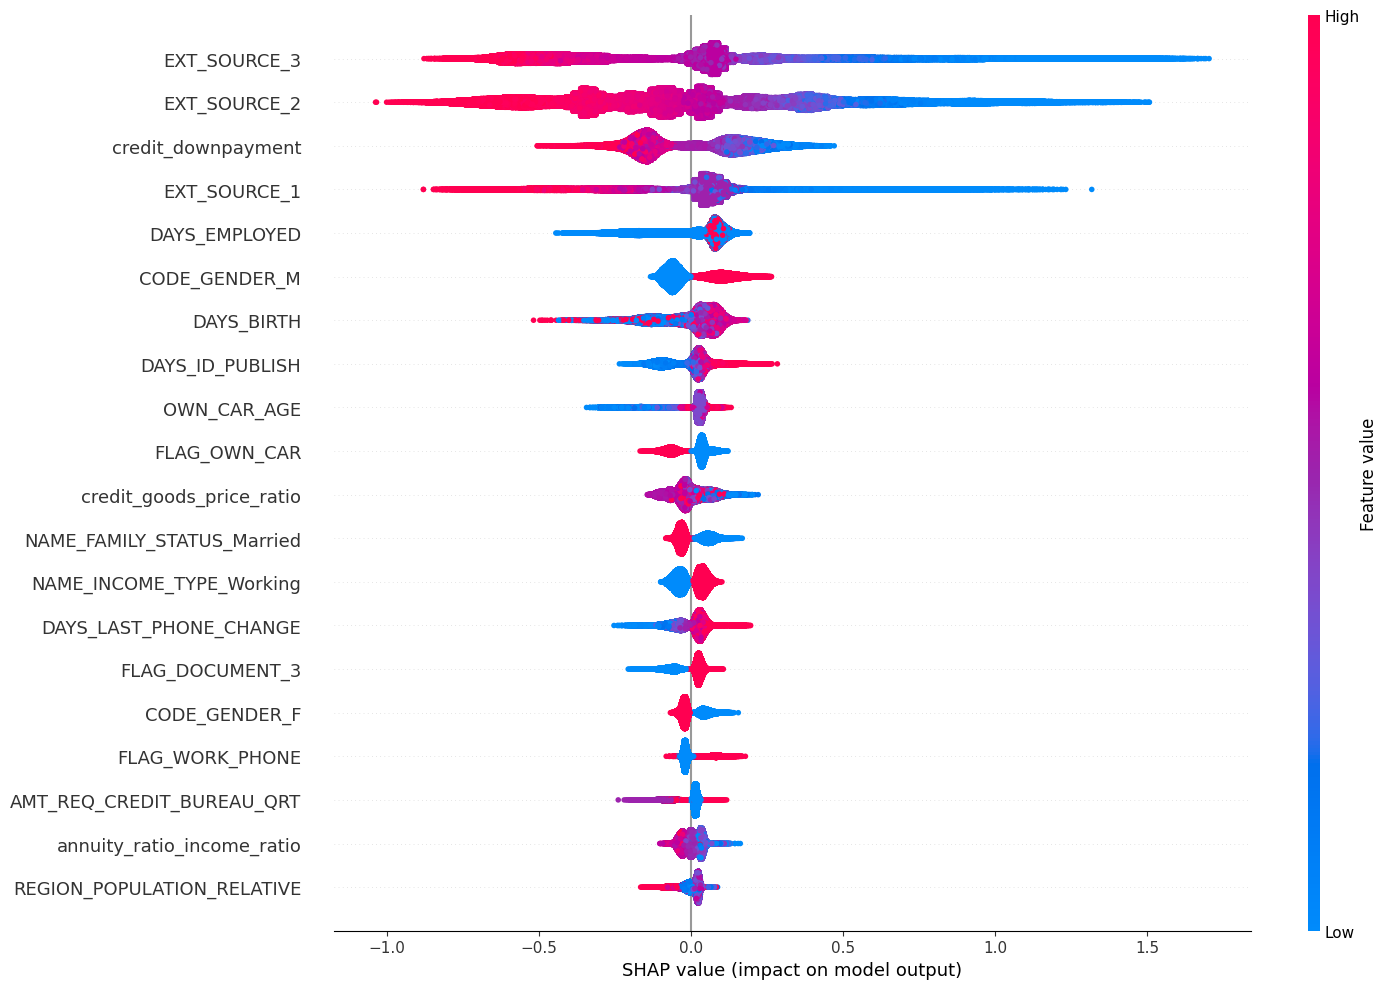

In [544]:
# summary_plot classe 1
shap.summary_plot(shap_values[1], X_train, plot_type="dot", plot_size = (15,10))

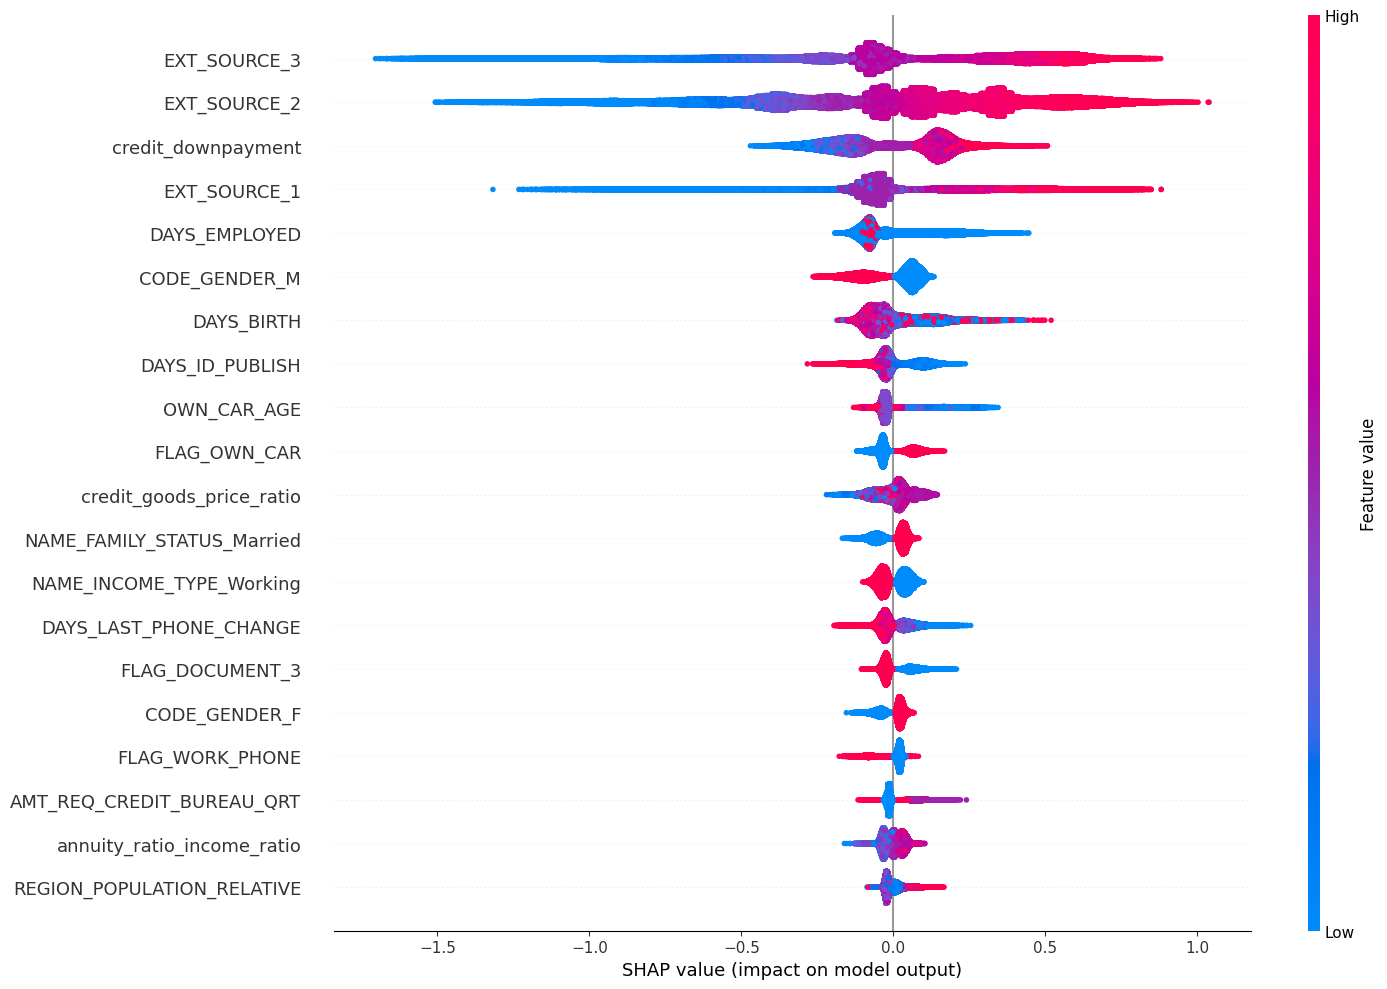

In [547]:
# summary_plot classe 0
shap.summary_plot(shap_values[0], X_train, plot_type="dot", plot_size = (15,10))

*  The SHAP value plot can show the positive and negative relationships of the predictors with the target variable. The code shap.summary_plot(shap_values, X_train)produces the feature important plot:
* This plot is made of all the dots in the train data. It delivers the following information:
* 1. Feature importance: Variables are ranked in descending order.
* 2. Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction
* 3. Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

## Individual SHAP Value Plot — local Interpretability (force_plot lightgbm)

In [584]:
# Force plot Lightgbm for observation 1
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][24000], X_train.values[24000], feature_names = X_train.columns)


In [664]:
shap.force_plot(explainer.expected_value[0], shap_values[0][35000], X_train.values[35000], feature_names = X_train.columns)


In [675]:
X_train.iloc[[35000]]

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,annuity_ratio_income_ratio,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment
5921,-0.324395,-0.717914,-1.50482,0.807273,-0.127762,-0.090973,-0.478972,-0.664763,-0.992944,-0.146313,...,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,-0.857697,-2.15351,0.807695,-0.04599


In [681]:
dtA = X_train.loc[X_train.index == 5921, :]

In [682]:
explainer = shap.TreeExplainer(lgbm_thre)
shap_values1 = explainer.shap_values(dtA)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [683]:
shap.force_plot(explainer.expected_value[0], shap_values1[0], dtA.values, feature_names = X_train.columns)

In [614]:
dtA

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,annuity_ratio_income_ratio,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment
35000,-0.324395,-0.717914,-1.50482,-0.577538,1.832942,-1.494508,2.133617,0.775536,-0.866408,-0.146313,...,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,1.555047,-1.047876,1.558282,-0.138605


In [587]:
# Mean calculate for local interpretability
X_train_mean_table = pd.DataFrame(X_train.mean())
print(X_train_mean_table[X_train_mean_table.index == 'EXT_SOURCE_3'])

print(X_train_mean_table[X_train_mean_table.index == 'EXT_SOURCE_2'])

print(X_train_mean_table[X_train_mean_table.index == 'credit_downpayment'])

print(X_train_mean_table[X_train_mean_table.index == 'DAYS_EMPLOYED'])

print(X_train_mean_table[X_train_mean_table.index == 'CODE_GENDER_M'])

print(X_train_mean_table[X_train_mean_table.index == 'AMT_REQ_CREDIT_BUREAU_QRT'])

print(X_train_mean_table[X_train_mean_table.index == 'credit_goods_price_ratio'])


                    0
EXT_SOURCE_3  0.00043
                     0
EXT_SOURCE_2  0.001357
                           0
credit_downpayment -0.000135
                      0
DAYS_EMPLOYED -0.000165
                      0
CODE_GENDER_M -0.000582
                                  0
AMT_REQ_CREDIT_BUREAU_QRT  0.000191
                                 0
credit_goods_price_ratio  0.934317


### The explain ability for any individual observation is the most critical step to convince your audience to adopt your model. Now, i'm going to interpret locally with 4 frist features. Note that Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

* For observation 24000, EXT_SOURCE_3 has a positive impact on the TARGET. The EXT_SOURCE_3 of this prediction is 0.3564, which is higher than the average value 0.00043. So it pushes the prediction to the right. And DAYS_EMPLOYED
* DAYS_EMPLOYED has a negative impact. A lower than the average (-0.4965 < -0.000165) drives the prediction to the right.
* EXT_SOURCE_2(-1.329) is positively related to the target which is lower than the averages 0.001357. So It pushes the prediction to the left. 
* CODE_GENDER_M (1.388): negative impact because his prediction is higher the average value -0.00058.

* Observation 35000 : 
* EXT_SOURCE_3 (0.7097) has a positive impact on the TARGET. The EXT_SOURCE_3 of this prediction is 0.7097 , which is higher than the average value 0.00043. So it pushes the prediction to the right.
* DAYS_EMPLOYED (-0.479) has a negative impact. A lower than the average (-0.4965 < -0.000165) drives the prediction to the right.
* credit_downpayment (-0.046) : has a positive impact because his prediction for this observation is -0.046 which is lower the -0.000135. so he makes a lower prediction and push the prediction to the left.
* credit_goods_price_ratio (0.8077): positive impact because his mean prediction is lower the average value 0.934317.

# FastAPI

### Save le dataset, model, and threshold

In [703]:
# save my dataframe
new_complet_data_lgbm = complet_data_lgbm.drop(['SK_ID_CURR'], axis=1)
new_complet_data_lgbm['SK_ID_CURR'] = app_train['SK_ID_CURR']
new_complet_data_lgbm = new_complet_data_lgbm.sample(40000, random_state=0)
joblib.dump(new_complet_data_lgbm,'data.joblib')

['data.joblib']

In [704]:
new_complet_data_lgbm['TARGET'].value_counts()

0    36814
1     3186
Name: TARGET, dtype: int64

In [532]:
# save my threshold_proba
joblib.dump(threshold_proba, 'threshold.joblib')

['threshold.joblib']

In [525]:
# save my
joblib.dump(lgbm_thre, 'classifier.joblib')

['classifier.joblib']

In [526]:
joblib.load('classifier.joblib')

LGBMClassifier(class_weight='balanced', max_depth=6, num_leaves=16,
               reg_alpha=0.01778279410038923, reg_lambda=5.623413251903491)

In [741]:
# Origale data for streamlit
app_train_api = pd.read_csv('application_train.csv')
app_train_api = app_train_api.sample(40000, random_state=0)
app_train_api['AGE'] = (-app_train_api['DAYS_BIRTH']/365)
app_train_api['TARGET'].value_counts()

0    36814
1     3186
Name: TARGET, dtype: int64

In [735]:
app_train_api['NAME_INCOME_TYPE']

42962                  Working
227307    Commercial associate
290035    Commercial associate
239833                 Working
76427                  Working
                  ...         
37710                Pensioner
146273                 Working
21948                  Working
249199               Pensioner
90125                  Working
Name: NAME_INCOME_TYPE, Length: 40000, dtype: object

In [743]:
import joblib
joblib.dump(app_train_api,'app_train_api.joblib')

['app_train_api.joblib']